In [27]:


import torch
import torchvision
import torchaudio
import sklearn
import matplotlib
import cv2
import PIL
import tqdm
import seaborn
import numpy as np

print("All libraries imported successfully!\n")

import sys
print(f"Python version: {sys.version}")
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"PIL version: {PIL.__version__}")


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available and will be used on Apple Silicon (M1/M2).")
else:
    device = torch.device("cpu")
    print("MPS backend not available, using CPU.")

x = torch.rand(3,3).to(device)
print("Random tensor on device:", x)


All libraries imported successfully!

Python version: 3.10.18 (main, Jun  3 2025, 18:23:41) [Clang 17.0.0 (clang-1700.0.13.3)]
Torch version: 2.4.1
Torchvision version: 0.19.1
Torchaudio version: 2.4.1
Scikit-learn version: 1.3.2
Matplotlib version: 3.7.5
OpenCV version: 4.11.0
PIL version: 11.3.0
MPS backend is available and will be used on Apple Silicon (M1/M2).
Random tensor on device: tensor([[0.0816, 0.5286, 0.3408],
        [0.8919, 0.4733, 0.7385],
        [0.1591, 0.8248, 0.5469]], device='mps:0')


In [28]:


import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


root_dir = "/Users/tejanimbagallu/Documents/ME CS/1-1/ADM/Project/dataset"

IMG_SIZE = 250
BATCH_SIZE = 32


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_dir = os.path.join(root_dir, "train")
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

val_clean_dir = os.path.join(root_dir, "val", "clean")
val_noisy_dir = os.path.join(root_dir, "val", "noisy")
val_clean_dataset = datasets.ImageFolder(root=val_clean_dir, transform=transform)
val_noisy_dataset = datasets.ImageFolder(root=val_noisy_dir, transform=transform)

test_clean_dir = os.path.join(root_dir, "test", "clean")
test_noisy_dir = os.path.join(root_dir, "test", "noisy")
test_clean_dataset = datasets.ImageFolder(root=test_clean_dir, transform=transform)
test_noisy_dataset = datasets.ImageFolder(root=test_noisy_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_clean_loader = DataLoader(val_clean_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_noisy_loader = DataLoader(val_noisy_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_clean_loader = DataLoader(test_clean_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_noisy_loader = DataLoader(test_noisy_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(f"Train set size: {len(train_dataset)} images, {len(class_to_idx)} classes")
print(f"Val Clean size: {len(val_clean_dataset)} images")
print(f"Val Noisy size: {len(val_noisy_dataset)} images")
print(f"Test Clean size: {len(test_clean_dataset)} images")
print(f"Test Noisy size: {len(test_noisy_dataset)} images")

Train set size: 9800 images, 35 classes
Val Clean size: 2800 images
Val Noisy size: 2800 images
Test Clean size: 1400 images
Test Noisy size: 1400 images


In [9]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    """
    A compact CNN for 250x250 face images with 35 classes.
    Includes conv blocks, batchnorm, ReLU, dropout, and global avg pooling.
    """

    def __init__(self, num_classes=35, dropout=0.4):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) 
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )


        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) 
        )


        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(512, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1) 
        x = self.dropout(x)
        x = self.fc(x)
        return x


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CustomCNN(num_classes=len(class_to_idx)).to(device)
print(model)


CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride

In [ ]:

import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

@torch.no_grad()
def evaluate(model, loader, criterion, device, num_classes=35, plot_roc=False):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    try:
        y_true_bin = np.eye(num_classes)[all_labels]
        auc = roc_auc_score(y_true_bin, np.array(all_probs), average="macro", multi_class="ovr")
    except Exception:
        auc = None

    if plot_roc and auc is not None:
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(all_probs).ravel())
        plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curve (macro)")
        plt.legend()
        plt.show()

    return {
        "loss": epoch_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm
    }



EPOCHS = 40
best_acc = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_metrics = evaluate(model, val_clean_loader, criterion, device, num_classes=len(class_to_idx))

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_metrics["loss"],
        "val_acc": val_metrics["accuracy"],
        "val_f1": val_metrics["f1"]
    })

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, "
          f"F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']}")

    if val_metrics["accuracy"] > best_acc:
        best_acc = val_metrics["accuracy"]
        torch.save(model.state_dict(), "best_customcnn.pth")
        print("✅ Saved Best Model")

print("Training finished!")


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.2871, Train Acc: 0.3342 | Val Loss: 2.3263, Val Acc: 0.3332, F1: 0.3149, AUC: 0.9038390231092436
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 2/40 | Train Loss: 2.2196, Train Acc: 0.3614 | Val Loss: 2.1897, Val Acc: 0.3650, F1: 0.3475, AUC: 0.9128844537815126
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 3/40 | Train Loss: 2.1681, Train Acc: 0.3744 | Val Loss: 2.1709, Val Acc: 0.3579, F1: 0.3387, AUC: 0.9154623161764706


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 4/40 | Train Loss: 2.1075, Train Acc: 0.3938 | Val Loss: 2.0985, Val Acc: 0.3839, F1: 0.3650, AUC: 0.9224725577731094
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 5/40 | Train Loss: 2.0462, Train Acc: 0.4073 | Val Loss: 2.1565, Val Acc: 0.3668, F1: 0.3556, AUC: 0.9217693014705883


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 6/40 | Train Loss: 1.9943, Train Acc: 0.4280 | Val Loss: 2.0477, Val Acc: 0.3993, F1: 0.3821, AUC: 0.9275882352941177
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 7/40 | Train Loss: 1.9335, Train Acc: 0.4517 | Val Loss: 2.0377, Val Acc: 0.4054, F1: 0.3941, AUC: 0.9249206932773107
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 8/40 | Train Loss: 1.8762, Train Acc: 0.4686 | Val Loss: 1.9847, Val Acc: 0.4357, F1: 0.4389, AUC: 0.9312678571428571
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 9/40 | Train Loss: 1.8188, Train Acc: 0.4884 | Val Loss: 1.8846, Val Acc: 0.4632, F1: 0.4568, AUC: 0.9400051207983194
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 10/40 | Train Loss: 1.7604, Train Acc: 0.5022 | Val Loss: 1.7909, Val Acc: 0.4807, F1: 0.4667, AUC: 0.9436712184873949
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 11/40 | Train Loss: 1.6872, Train Acc: 0.5297 | Val Loss: 1.7746, Val Acc: 0.4789, F1: 0.4756, AUC: 0.9474296218487394


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 12/40 | Train Loss: 1.6310, Train Acc: 0.5483 | Val Loss: 1.7612, Val Acc: 0.5061, F1: 0.5023, AUC: 0.9477991071428572
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 13/40 | Train Loss: 1.5825, Train Acc: 0.5648 | Val Loss: 2.1128, Val Acc: 0.4025, F1: 0.3861, AUC: 0.9342454044117646


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 14/40 | Train Loss: 1.5196, Train Acc: 0.5817 | Val Loss: 1.7357, Val Acc: 0.5029, F1: 0.5015, AUC: 0.9514251575630253


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 15/40 | Train Loss: 1.4672, Train Acc: 0.5947 | Val Loss: 1.7711, Val Acc: 0.4821, F1: 0.4686, AUC: 0.9502614233193276


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 16/40 | Train Loss: 1.4266, Train Acc: 0.6086 | Val Loss: 1.8318, Val Acc: 0.4714, F1: 0.4731, AUC: 0.9488360031512605


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 17/40 | Train Loss: 1.3593, Train Acc: 0.6332 | Val Loss: 1.6932, Val Acc: 0.5204, F1: 0.5144, AUC: 0.9525961134453782
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 18/40 | Train Loss: 1.3179, Train Acc: 0.6424 | Val Loss: 1.6485, Val Acc: 0.5207, F1: 0.5119, AUC: 0.9597748161764706
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 19/40 | Train Loss: 1.2692, Train Acc: 0.6535 | Val Loss: 2.0444, Val Acc: 0.4025, F1: 0.3829, AUC: 0.9493555672268907


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 20/40 | Train Loss: 1.2191, Train Acc: 0.6737 | Val Loss: 1.6567, Val Acc: 0.5193, F1: 0.5153, AUC: 0.9591251313025209


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 21/40 | Train Loss: 1.1690, Train Acc: 0.6911 | Val Loss: 1.6221, Val Acc: 0.5104, F1: 0.5233, AUC: 0.9622547268907563


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 22/40 | Train Loss: 1.1078, Train Acc: 0.7059 | Val Loss: 1.4781, Val Acc: 0.5721, F1: 0.5742, AUC: 0.9663412552521008
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 23/40 | Train Loss: 1.0738, Train Acc: 0.7163 | Val Loss: 2.1203, Val Acc: 0.4357, F1: 0.4196, AUC: 0.9409193802521009


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 24/40 | Train Loss: 1.0300, Train Acc: 0.7269 | Val Loss: 1.5335, Val Acc: 0.5625, F1: 0.5566, AUC: 0.9645196953781513


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 25/40 | Train Loss: 0.9984, Train Acc: 0.7357 | Val Loss: 1.3857, Val Acc: 0.5993, F1: 0.6005, AUC: 0.9696433823529412
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 26/40 | Train Loss: 0.9603, Train Acc: 0.7406 | Val Loss: 1.6021, Val Acc: 0.5400, F1: 0.5364, AUC: 0.9654044117647059


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 27/40 | Train Loss: 0.9088, Train Acc: 0.7568 | Val Loss: 1.6363, Val Acc: 0.5254, F1: 0.5130, AUC: 0.9672752100840335


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 28/40 | Train Loss: 0.8886, Train Acc: 0.7646 | Val Loss: 1.3463, Val Acc: 0.6221, F1: 0.6248, AUC: 0.9702121848739497
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 29/40 | Train Loss: 0.8366, Train Acc: 0.7845 | Val Loss: 1.2378, Val Acc: 0.6600, F1: 0.6588, AUC: 0.9750659138655463
✅ Saved Best Model


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 30/40 | Train Loss: 0.8037, Train Acc: 0.7921 | Val Loss: 1.6680, Val Acc: 0.5089, F1: 0.5032, AUC: 0.9668541885504202


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 31/40 | Train Loss: 0.7619, Train Acc: 0.8033 | Val Loss: 1.4121, Val Acc: 0.6061, F1: 0.6101, AUC: 0.9712683823529413


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 32/40 | Train Loss: 0.7209, Train Acc: 0.8183 | Val Loss: 1.6562, Val Acc: 0.5032, F1: 0.5146, AUC: 0.9685380777310926


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 33/40 | Train Loss: 0.6949, Train Acc: 0.8251 | Val Loss: 1.5890, Val Acc: 0.5375, F1: 0.5406, AUC: 0.9721775210084033


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 34/40 | Train Loss: 0.6812, Train Acc: 0.8267 | Val Loss: 1.2613, Val Acc: 0.6257, F1: 0.6190, AUC: 0.9753715861344537


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 35/40 | Train Loss: 0.6430, Train Acc: 0.8400 | Val Loss: 1.3022, Val Acc: 0.6386, F1: 0.6454, AUC: 0.975748818277311


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 36/40 | Train Loss: 0.6031, Train Acc: 0.8487 | Val Loss: 1.4334, Val Acc: 0.5804, F1: 0.5873, AUC: 0.9723665966386554


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 37/40 | Train Loss: 0.5775, Train Acc: 0.8562 | Val Loss: 1.3862, Val Acc: 0.6075, F1: 0.6148, AUC: 0.9760332195378151


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 38/40 | Train Loss: 0.5607, Train Acc: 0.8597 | Val Loss: 2.2598, Val Acc: 0.4275, F1: 0.4060, AUC: 0.9631893382352942


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 39/40 | Train Loss: 0.5331, Train Acc: 0.8686 | Val Loss: 1.3390, Val Acc: 0.6118, F1: 0.6118, AUC: 0.9754439338235292


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Epoch 40/40 | Train Loss: 0.5025, Train Acc: 0.8787 | Val Loss: 1.5160, Val Acc: 0.5829, F1: 0.5893, AUC: 0.9742876838235291
Training finished!


In [ ]:

import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

best_model = CustomCNN(num_classes=35).to(device)
best_model.load_state_dict(torch.load("best_customcnn.pth", map_location=device))
best_model.eval()

def evaluate_model(model, dataloader, name="Dataset"):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
    except:
        auc = float("nan") 

    print(f"📊 {name} -> Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    return acc, f1, auc


val_clean = evaluate_model(best_model, val_clean_loader, "Validation (Clean)")
val_noisy = evaluate_model(best_model, val_noisy_loader, "Validation (Noisy)")
test_clean = evaluate_model(best_model, test_clean_loader, "Test (Clean)")
test_noisy = evaluate_model(best_model, test_noisy_loader, "Test (Noisy)")

def compute_robustness(clean_metrics, noisy_metrics, name="Dataset"):
    clean_acc, clean_f1, clean_auc = clean_metrics
    noisy_acc, noisy_f1, noisy_auc = noisy_metrics

    acc_robust = noisy_acc / clean_acc if clean_acc > 0 else 0
    f1_robust = noisy_f1 / clean_f1 if clean_f1 > 0 else 0
    auc_robust = noisy_auc / clean_auc if clean_auc > 0 else 0

    print(f"Robustness ({name}) -> Acc: {acc_robust:.4f}, F1: {f1_robust:.4f}, AUC: {auc_robust:.4f}")

compute_robustness(val_clean, val_noisy, "Validation")
compute_robustness(test_clean, test_noisy, "Test")



/var/folders/00/j4l6fnbd2xbdy96tqx6mv8t80000gn/T/ipykernel_8731/576859344.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_cus

📊 Validation (Clean) -> Acc: 0.6600, F1: 0.6588, AUC: 0.9751
📊 Validation (Noisy) -> Acc: 0.6450, F1: 0.6453, AUC: 0.9723
📊 Test (Clean) -> Acc: 0.6529, F1: 0.6540, AUC: 0.9720
📊 Test (Noisy) -> Acc: 0.6357, F1: 0.6369, AUC: 0.9693
Robustness (Validation) -> Acc: 0.9773, F1: 0.9795, AUC: 0.9972
Robustness (Test) -> Acc: 0.9737, F1: 0.9739, AUC: 0.9972


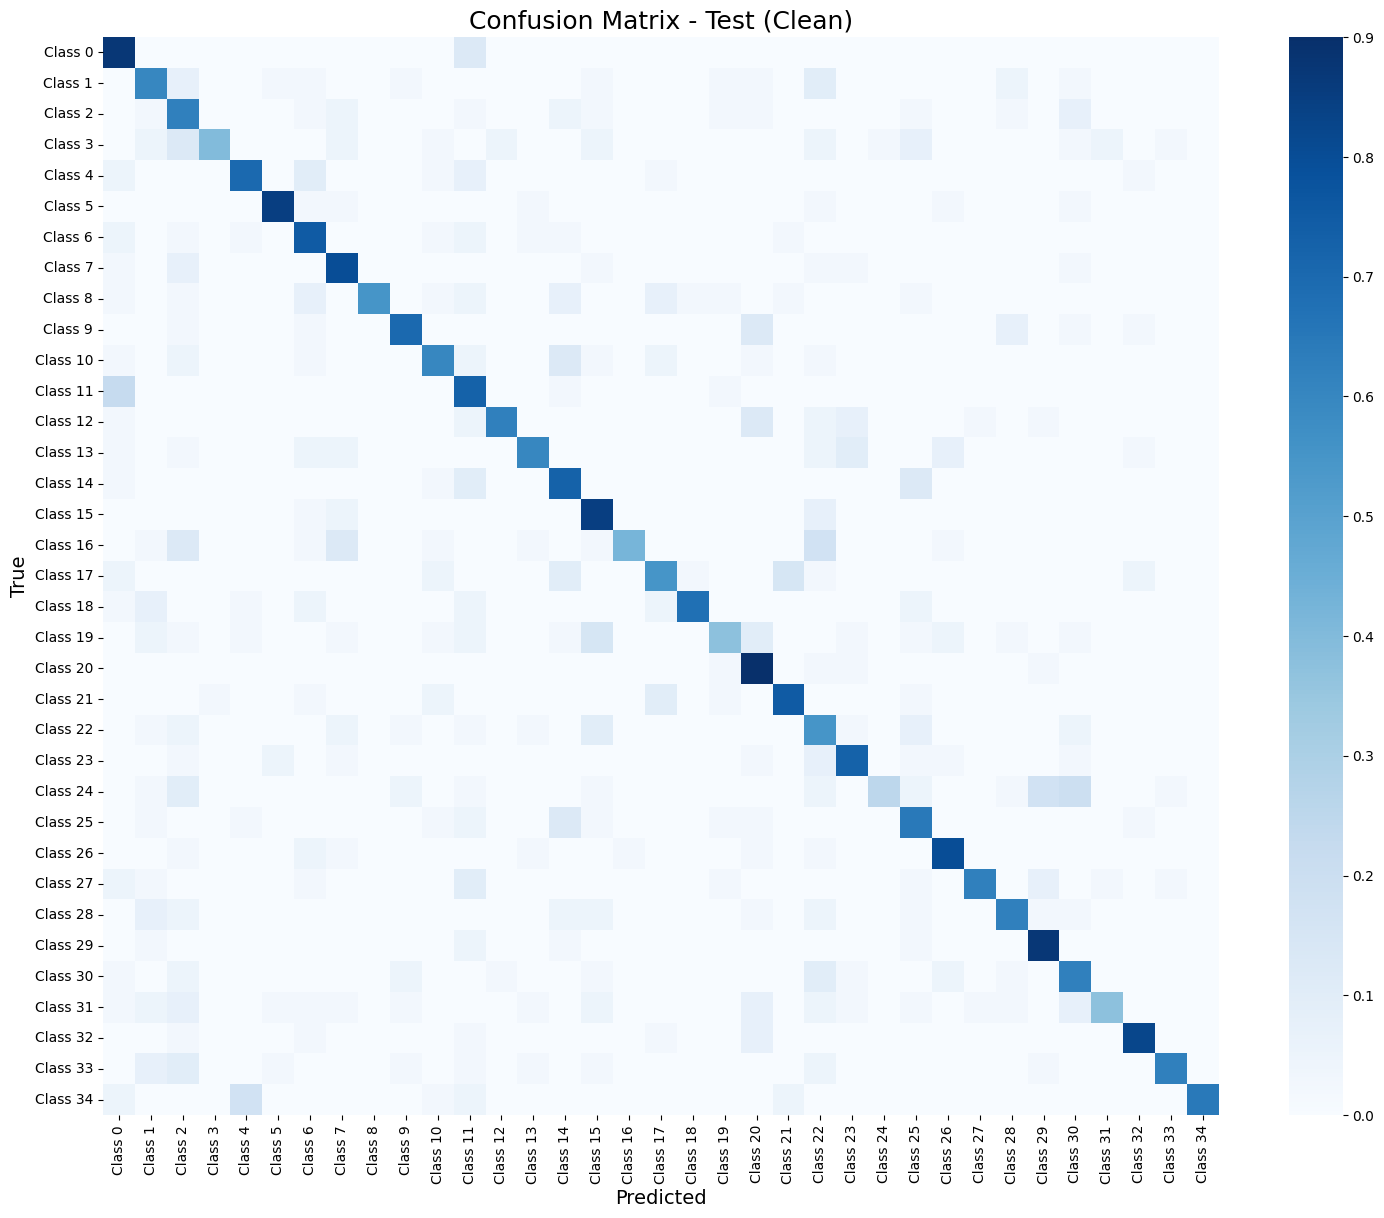

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, dataloader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))


    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(18, 14))
    sns.heatmap(cm_norm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=18)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

class_names = [f"Class {i}" for i in range(35)]
plot_confusion_matrix(best_model, test_clean_loader, class_names, title="Confusion Matrix - Test (Clean)")


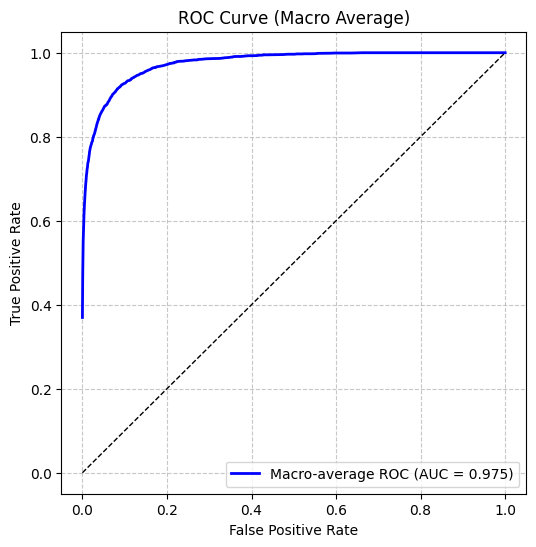

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

best_model.eval()
all_labels, all_probs = [], []

with torch.no_grad():
    for images, labels in val_clean_loader:   
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_labels)   
y_probs = np.array(all_probs)   

n_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))


fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6,6))
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Macro Average)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [26]:
import torch
import numpy as np

def compute_far_frr(model, dataloader, device, threshold=0.5):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)

            preds = torch.argmax(probs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    y_true = np.concatenate(all_labels)   
    y_probs = np.concatenate(all_probs)     
    y_pred = np.concatenate(all_preds)        


    y_scores = y_probs.max(axis=1)
    y_binary = (y_scores >= threshold).astype(int)

    y_true_binary = (y_pred == y_true).astype(int)

    FAR = ((y_binary == 1) & (y_true_binary == 0)).sum() / max((y_true_binary == 0).sum(), 1)

    FRR = ((y_binary == 0) & (y_true_binary == 1)).sum() / max((y_true_binary == 1).sum(), 1)

    print(f"FAR: {FAR:.4f}, FRR: {FRR:.4f}")
    return FAR, FRR

FAR, FRR = compute_far_frr(best_model, test_clean_loader, device, threshold=0.5)


FAR: 0.2037, FRR: 0.2440
